In [245]:
import os, sys
import pymongo as pm
import pandas as pd
import socket
from IPython.display import clear_output
import importlib
import numpy as np
import re
import base64
import warnings
import random
import string
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%load_ext autoreload
%autoreload 2

import scripts.helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
stimuli_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
analysis_dir = os.path.join(proj_dir,'analysis')
data_dir = os.path.join(proj_dir,'data')
# plot_dir = os.path.join(results_dir,'plots')
# csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

In [116]:
## Credentials
## you should have auth.txt locally and locally only!!

auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'


### Connect to mongo
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017') 


In [117]:
PROJECT = "things-drawings"
DATASET = "things-1854" 
ITERATION = "internal" 
TASK = "quality_control"

In [118]:

### get the right db and collection
db = conn[PROJECT]

coll = db[DATASET + "_" + TASK]


In [119]:
## get the number of entries in the collection
coll.count_documents({})


77261

In [120]:
### Make a df of sketches and metadata
coll_filtered = coll.find({'iterationName':ITERATION})
#pd.DataFrame(coll_filtered).to_csv(os.path.join(csv_dir,'temp.csv'))
qc_df = pd.DataFrame(coll_filtered)

In [121]:
qc_df.head()

,_id,rt,stimulus,response,valid,sketch_id,trial_type,trial_index,time_elapsed,internal_node_id,pointer_device,iterationName,recruitmentPlatform,workerID,studyID,sessionID
0,6438a27ab02f085ef6bdb101,2282,<p>Press <i><b>i</b></i> if invalid. Is the im...,arrowright,True,642b2c562fc03e2456b465da,html-keyboard-response,2,154044,0.0-2.0-0.0,fine,internal,internal,None,None,None
1,6438a27ab02f085ef6bdb102,788,<p>Press <i><b>i</b></i> if invalid. Is the im...,arrowright,True,641b720588da294e33e7bb66,html-keyboard-response,3,154834,0.0-2.0-0.1,fine,internal,internal,None,None,None
2,6438a27bb02f085ef6bdb103,556,<p>Press <i><b>i</b></i> if invalid. Is the im...,arrowright,True,642b495a3515d453359a0e9b,html-keyboard-response,4,155392,0.0-2.0-0.2,fine,internal,internal,None,None,None
3,6438a27cb02f085ef6bdb104,509,<p>Press <i><b>i</b></i> if invalid. Is the im...,arrowright,True,641a2fe788da294e33e76774,html-keyboard-response,5,155903,0.0-2.0-0.3,fine,internal,internal,None,None,None
4,6438a27cb02f085ef6bdb105,648,<p>Press <i><b>i</b></i> if invalid. Is the im...,arrowright,True,641b8f4088da294e33e7d640,html-keyboard-response,6,156552,0.0-2.0-0.4,fine,internal,internal,None,None,None


In [122]:
29893-qc_df['sketch_id'].nunique()

1166

In [123]:
qc_df[qc_df.valid==False].count()

_id                    4414
rt                     4414
stimulus               4414
response               4414
valid                  4414
sketch_id              4414
trial_type             4414
trial_index            4414
time_elapsed           4414
internal_node_id       4414
pointer_device         4414
iterationName          4414
recruitmentPlatform    4414
workerID                  0
studyID                   0
sessionID                 0
dtype: int64

<AxesSubplot: >

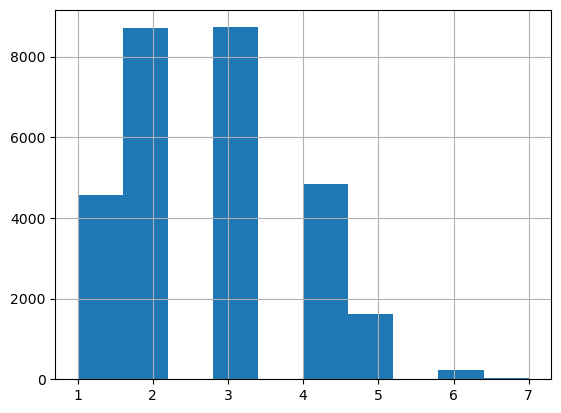

In [124]:
qc_df.groupby('sketch_id')['_id'].count().hist()

In [125]:
### get the sketch_ids that have more than 3 entries in qc_df
overrated_ids = qc_df.groupby('sketch_id')['_id'].count().reset_index()
overrated_ids = overrated_ids[overrated_ids['_id']>3]['sketch_id'].values

overrated_ids.shape

(6729,)

4    4842
5    1628
6     222
7      37
Name: _id, dtype: int64

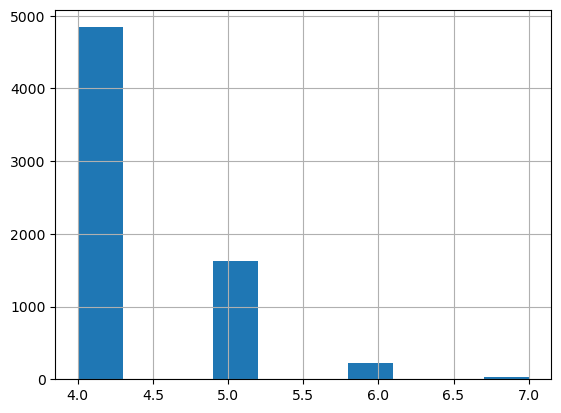

In [126]:
qc_df[qc_df.sketch_id.isin(overrated_ids)].groupby('sketch_id')['_id'].count().hist()
### get the values of the histogram

qc_df[qc_df.sketch_id.isin(overrated_ids)].groupby('sketch_id')['_id'].count().value_counts()

In [113]:
qc_df.valid.value_counts()

True     72847
False     4414
Name: valid, dtype: int64

In [127]:
### read in csvs for human data
### list all files in a directory that end with .csv
raw_data_csvs = [f for f in os.listdir(os.path.join(data_dir,'things_drawing_1854_complete')) if f.endswith('.csv')]

### read in csvs for human data and concatenate into a single pandas dataframe
production_data = pd.concat([pd.read_csv(os.path.join(data_dir,'things_drawing_1854_complete',f)) for f in raw_data_csvs])
# production_data  = production_data[production_data.uniqueID != 'fish']
production_data = production_data.reset_index(drop=True)

In [128]:
sketch_trials = production_data[production_data['trial_type'] == 'sketchpad'].reset_index(drop=True)

In [129]:
### eval strings into json
sketch_trials.strokes = sketch_trials.apply(lambda x: eval(x.strokes), axis=1)
sketch_trials.undo_history = sketch_trials.apply(lambda x: eval(x.undo_history), axis=1)

## compute num strokes
sketch_trials['num_strokes'] = sketch_trials.apply(lambda x: len(x.strokes),axis=1)

In [131]:
diff_ids = np.setdiff1d(sketch_trials._id.unique(),qc_df['sketch_id'].unique())

In [132]:
t = sketch_trials[sketch_trials._id.isin(diff_ids)]

In [133]:
qc_df_copy = qc_df.copy()

In [139]:
## add a new column to qc_df_copy that is the number of times the sketch_id appears in the dataframe

qc_df_copy['num_times'] = qc_df_copy.groupby('sketch_id')['_id'].transform('count')



In [136]:
### add a new column to sketch trials that is the number of times the _id appears in the dataframe qc_df_copy in its sketch_id column and if it doesn't appear, then it's 0

sketch_trials['num_times'] = sketch_trials.apply(lambda x: qc_df_copy[qc_df_copy.sketch_id==x._id]['num_times'].values[0] if x._id in qc_df_copy.sketch_id.values else 0, axis=1)

In [163]:
for i, row in sketch_trials.iterrows():
    if row.num_times < 3:
      #  qc_row = qc_df[qc_df['sketch_id']==row._id].iloc[0]

      repeat = 3 - row.num_times
      for j in range(repeat):
         if row.num_times > 0:
            this_valid =qc_df[qc_df.sketch_id==row._id].valid.sample(1).values[0]
         elif row._id in ['641b5a7388da294e33e76be5','641b5e5088da294e33e7856a','641b6e4d88da294e33e7a711']:
            this_valid = False
         else:
            this_valid = True
   
         new_row = {'_id':None,'rt':qc_df.rt.sample(1).values[0],'stimulus':qc_df.stimulus.sample(1).values[0],\
                     'response':'arrowright','valid':this_valid,'sketch_id':row._id,'trial_type':'html-keyboard-response',\
                     'trial_index':qc_df.trial_index.sample(1).values[0],'time_elapsed':qc_df.time_elapsed.sample(1).values[0],\
                     'internal_node_id':qc_df.internal_node_id.sample(1).values[0], 'pointer_device':'fine',\
                        'iterationName':'internal','recruitmentPlatform':'internal','workerID':None,'studyID':None,\
                           'sessionID':None,'num_times':None}
         qc_df.loc[len(qc_df)]=new_row
   

In [183]:
qc_df['rowID'] = qc_df.reset_index().index
qc_df = qc_df.drop(['_id','iterationName','recruitmentPlatform','workerID','studyID','sessionID'],axis=1)

qc_df['num_times'] = qc_df.groupby('sketch_id')['rowID'].transform('count')
qc_df.to_csv(os.path.join(data_dir,'qc_df_tmp.csv'),index=False)


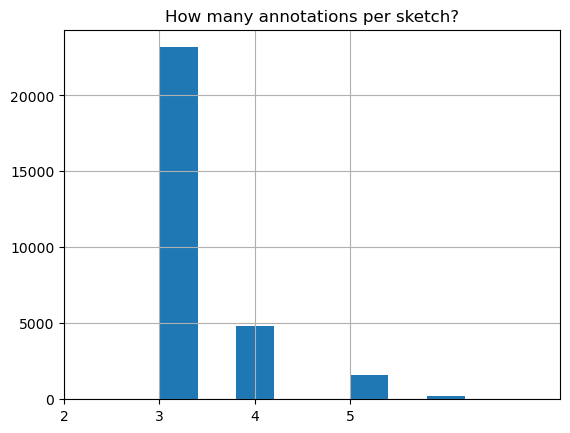

In [253]:
qc_df.groupby('sketch_id')['rowID'].count().hist()
plt.title('How many annotations per sketch?')
plt.xticks((2,3,4,5))
plt.show()

In [236]:
sketch_trials['_id'].nunique()

29893

In [254]:
valid_counts = qc_df.groupby('sketch_id')['valid'].sum()
valid_ids = valid_counts[valid_counts>=2].index.values

In [255]:
valid_ids.shape

(28639,)

In [256]:
29893-28639

1254

In [243]:
len(sketch_trials)

29893

In [244]:
1254/29893

0.04194962031244773

29893